<a id='libraries'></a>

# Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from time import time

random_state=42

<a id='Import_dataset'></a>

# Import dataset

In [3]:
# import danych i podgląd
df = pd.read_csv('winequality-red.csv')
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df_2 = df.copy()
df_2['quality']= [0 if x <= 4 else 1 if x <= 5 else 2 if x <=6 else 3 for x in df_2['quality']]
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [22]:
df_2.groupby("quality")["quality"].count()

quality
0     63
1    577
2    535
3    184
Name: quality, dtype: int64

<a id='Prepare_basic_models'></a>

# Prepare basic models

In [4]:
# different scallers might perform better
scalers = {'standard_scaler' : StandardScaler(),
           'max_abs_scaler' : MaxAbsScaler(),
           'robust_scaler' : RobustScaler(),
           'quantile_transformer_normal' : QuantileTransformer(output_distribution='normal'),
           'power_transformer_YeoJohnson' : PowerTransformer(method='yeo-johnson')}

In [5]:
# get number of classes for XGBoost classifier
num_of_classes = len(df_2['quality'].unique())

# get weight of each class for XGBoost classifier
target = df_2['quality']
class_0_proportion = len(target[target==0]) / len(target)
class_1_proportion = len(target[target==1]) / len(target)
class_2_proportion = len(target[target==2]) / len(target)
class_3_proportion = len(target[target==3]) / len(target)

print(class_0_proportion, class_1_proportion, class_2_proportion, class_3_proportion)

class_0_weight = class_0_proportion / class_0_proportion
class_1_weight = class_0_proportion / class_1_proportion
class_2_weight = class_0_proportion / class_2_proportion
class_3_weight = class_0_proportion / class_3_proportion

print(class_0_weight, class_1_weight, class_2_weight, class_3_weight)

0.046357615894039736 0.42457689477557026 0.3936718175128771 0.13539367181751288
1.0 0.10918544194107453 0.1177570093457944 0.34239130434782605


In [6]:
# XGBoost weghts migh be applied at training step - results of XGBoost might be uncomparable at this stage
basic_models = {'LogisticRegression': LogisticRegression(random_state=random_state, class_weight='balanced',max_iter=10000),
                'RandomForestClassifier': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
                'SVMClassifier': OneVsRestClassifier(SVC(random_state=random_state, class_weight='balanced')),
                'XGBoostClassifier': XGBClassifier(random_state=random_state, eval_metric='error', objective='multi:softprob', num_class=len(df_2['quality'].unique())),
                'KNeighborsClassifier' : KNeighborsClassifier()}

In [7]:
# split data into training/validation and test
X = df_2.iloc[:, :-1]
y = df_2.iloc[:, -1:].to_numpy().ravel()
test_size = .2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=y)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

In [8]:
def custom_final_score(cf, recall_0_weight, recall_3_weight):
        # recall_0 = cf[0][0] / sum(cf[0, :])
        # recall_3 = cf[3][3] / sum(cf[3, :])   
        custom_metric = (sum(cf[0, 1:4]) + sum(cf[3, 0:3]) + sum(cf[1:3, 0]) +  sum(cf[1:3, 3]))  /  sum(cf.flatten()) * -1
        # custom_final_score = (recall_0 * recall_0_weight + recall_3 * recall_3_weight + custom_metric)/3
        return custom_metric

In [9]:
def custom_final_score(cf, recall_0_weight, recall_3_weight):
        recall_0 = cf[0][0] / sum(cf[0, :])
        recall_3 = cf[3][3] / sum(cf[3, :])   
        custom_metric = (sum(cf[0, 1:4]) + sum(cf[3, 0:3]) + sum(cf[1:3, 0]) +  sum(cf[1:3, 3]))  /  sum(cf.flatten()) * -1
        custom_final_score = (recall_0 * recall_0_weight + recall_3 * recall_3_weight)/2 + custom_metric
        return custom_final_score

In [10]:
recall_0_weight = .75
recall_3_weight = .75

<a id='Cross_validate_basic_models'></a>

# Cross validate basic models

In [11]:
cv_metrics = pd.DataFrame()
f1_scores = []
precision_scores = []
recall_scores = []
custom_scores = []

for model_name, model in basic_models.items():
    for scaler_name, scaler in scalers.items():
        start = time()    
        
         
        pipeline_result = Pipeline([('scaler', scaler),
                                    ('model', model)])
        
        
        y_train_pred = cross_val_predict(pipeline_result, X_train, y_train, cv=skf)
        
        
        cf = confusion_matrix(y_train, y_train_pred)  
        custom_score = custom_final_score(cf, recall_0_weight, recall_3_weight)

    
        f1 = f1_score(y_train, y_train_pred, average="macro")
        precision = precision_score(y_train, y_train_pred, average="macro")
        recall = recall_score(y_train, y_train_pred, average="macro")

        end = time()
        cross_val_time = end-start
             
        
        cv_metrics[str(model_name + '_' +scaler_name)] = [model_name,
                                                          scaler_name,
                                                          precision,
                                                          recall,
                                                          f1,
                                                          custom_score,
                                                          cross_val_time]
        
cv_metrics.index = ['Model', 'Scaler', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
cv_metrics.T.sort_values(by="Custom", ascending=False)

,Model,Scaler,Precision,Recall,F1,Custom,Time
LogisticRegression_power_transformer_YeoJohnson,LogisticRegression,power_transformer_YeoJohnson,0.438726,0.529357,0.430505,0.108394,0.497548
LogisticRegression_quantile_transformer_normal,LogisticRegression,quantile_transformer_normal,0.42673,0.518132,0.414092,0.086162,0.440238
LogisticRegression_standard_scaler,LogisticRegression,standard_scaler,0.438897,0.519263,0.430139,0.08595,0.235791
LogisticRegression_robust_scaler,LogisticRegression,robust_scaler,0.434442,0.516385,0.426118,0.08411,0.314134
SVMClassifier_quantile_transformer_normal,SVMClassifier,quantile_transformer_normal,0.482004,0.493667,0.486148,0.062933,1.202266
SVMClassifier_standard_scaler,SVMClassifier,standard_scaler,0.483424,0.50164,0.490044,0.062001,1.025779
SVMClassifier_power_transformer_YeoJohnson,SVMClassifier,power_transformer_YeoJohnson,0.477001,0.483941,0.480206,0.055084,1.191165
SVMClassifier_robust_scaler,SVMClassifier,robust_scaler,0.48196,0.493426,0.485268,0.055071,1.016781
LogisticRegression_max_abs_scaler,LogisticRegression,max_abs_scaler,0.392974,0.485885,0.367734,0.028775,0.523561
SVMClassifier_max_abs_scaler,SVMClassifier,max_abs_scaler,0.443445,0.475162,0.446226,0.019572,1.106824


# Best basics models - Confusion Matrix and custom score

In [12]:
# best models confusion matrix on training data
best_basic_models = {"Logistic Regression": {"Model": basic_models["LogisticRegression"],
                                             "Scaler": scalers["power_transformer_YeoJohnson"]},
                     
                     "SVM": {"Model": basic_models["SVMClassifier"],
                             "Scaler": scalers["standard_scaler"]},
                     
                     "XGBoost": {"Model": basic_models["XGBoostClassifier"],
                                 "Scaler": scalers["quantile_transformer_normal"]}}

for model_name, model_details in best_basic_models.items():
    model = model_details.get('Model')
    scaler =model_details.get('Scaler')

    pipeline_result = Pipeline([('scaler', scaler),
                                ('model', model)])  
    
    y_training_pred = cross_val_predict(pipeline_result, X_train, y_train, cv=skf)      
    cf = confusion_matrix(y_train, y_training_pred)
    custom_score = custom_final_score(cf, recall_0_weight, recall_3_weight)
           
    
    print(model_name + " - training data", end="\n")
    print(f"Custom score: {custom_score:.2f}", end="\n")
    print(cf, end="\n\n\n")

Logistic Regression - training data
Custom score: 0.11
[[ 27  14   8   1]
 [111 250  77  24]
 [ 67  95 132 134]
 [  7   4  29 107]]


SVM - training data
Custom score: 0.06
[[ 15  22  12   1]
 [ 35 318  98  11]
 [ 21 105 232  70]
 [  3   9  65  70]]


XGBoost - training data
Custom score: -0.00
[[  5  29  16   0]
 [  6 329 120   7]
 [  2 130 249  47]
 [  0  10  81  56]]




In [13]:
# best models confusion matrix on test data
best_basic_models = {"Logistic Regression": {"Model": basic_models["LogisticRegression"],
                                             "Scaler": scalers["power_transformer_YeoJohnson"]},
                     
                     "SVM": {"Model": basic_models["SVMClassifier"],
                             "Scaler": scalers["standard_scaler"]},
                     
                     "XGBoost": {"Model": basic_models["XGBoostClassifier"],
                                 "Scaler": scalers["quantile_transformer_normal"]}}

for model_name, model_details in best_basic_models.items():
    model = model_details.get('Model')
    scaler =model_details.get('Scaler')

    pipeline_result = Pipeline([('scaler', scaler),
                                ('model', model)])  
    
    pipeline_result.fit(X_train, y_train)
    y_test_pred = pipeline_result.predict(X_test) 
       
    cf = confusion_matrix(y_test, y_test_pred)
    custom_score = custom_final_score(cf, recall_0_weight, recall_3_weight)
           
    
    print(model_name + " - test data", end="\n")
    print(f"Custom score: {custom_score:.2f}", end="\n")
    print(cf, end="\n\n\n")

Logistic Regression - test data
Custom score: 0.27
[[10  2  0  1]
 [29 56 22  8]
 [13 25 35 34]
 [ 2  0  3 32]]


SVM - test data
Custom score: 0.25
[[ 6  6  0  1]
 [ 9 68 34  4]
 [ 4 26 60 17]
 [ 0  1 10 26]]


XGBoost - test data
Custom score: 0.07
[[ 1  8  4  0]
 [ 0 84 29  2]
 [ 1 29 65 12]
 [ 0  3 14 20]]




# Tuning

In [14]:
# creating a cutom function to make custom scorer for GridSearch
def custom_metric(y_true, y_pred):
        cf = confusion_matrix(y_true, y_pred)
        recall_0 = cf[0][0] / sum(cf[0, :])
        recall_3 = cf[3][3] / sum(cf[3, :])   
        custom_metric = (sum(cf[0, 1:4]) + sum(cf[3, 0:3]) + sum(cf[1:3, 0]) +  sum(cf[1:3, 3]))  /  sum(cf.flatten()) * -1
        custom_final_score = (recall_0 + recall_3)/2 + custom_metric
        return custom_final_score

In [15]:
# LR tuning
LR_model_basic = basic_models["LogisticRegression"]
LR_scaler = scalers["power_transformer_YeoJohnson"]
                     
LR_pipeline_result = Pipeline([('scaler', LR_scaler),
                               ('model', LR_model_basic)])  

LR_parameter_grid = {'model__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]}

# creating a scorer for GridSearch
scorer = make_scorer(custom_metric, greater_is_better=True)
LR_grid = GridSearchCV(LR_pipeline_result,
                       LR_parameter_grid,
                       cv=skf,
                       scoring=scorer)
LR_model_tuned = LR_grid.fit(X_train, y_train)

LR_y_test_pred = LR_model_tuned.predict(X_test)      
LR_cf = confusion_matrix(y_test, LR_y_test_pred)
LR_custom_score = custom_final_score(LR_cf, recall_0_weight, recall_3_weight)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   random_state=42)
LogisticRegression - test data after tuning
LogisticRegression - custom score after tuning: 0.27
[[10  2  0  1]
 [29 56 22  8]
 [13 25 35 34]
 [ 2  0  3 32]]




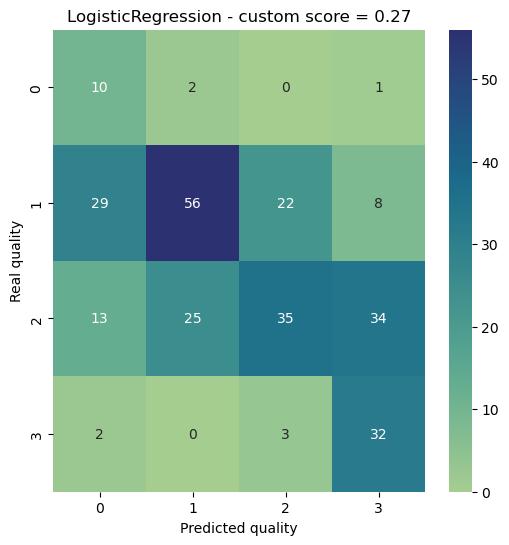

In [16]:
# LR scores
print(LR_grid.best_estimator_.steps[1][1])
print("LogisticRegression - test data after tuning", end="\n")
print(f"LogisticRegression - custom score after tuning: {LR_custom_score:.2f}", end="\n")
print(LR_cf, end="\n\n\n")

fig = plt.figure(figsize=(6,6))
ax= plt.subplot()
sns.heatmap(LR_cf,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")


ax.set_xlabel('Predicted quality')
ax.set_ylabel('Real quality')
ax.set_title(f'LogisticRegression - custom score = {LR_custom_score:.2f}')
pass

OneVsRestClassifier(estimator=SVC(C=2, class_weight='balanced', degree=2,
                                  gamma=0.01, random_state=42))
SVM - test data after tuning
SVM - custom score after tuning: 0.64
[[ 7  5  1  0]
 [12 70 26  7]
 [ 8 32 50 17]
 [ 1  1  6 29]]




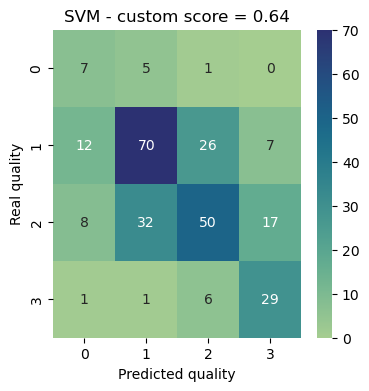

In [47]:
# SVM tuning
SVM_model_basic = basic_models["SVMClassifier"]
SVM_scaler = scalers["standard_scaler"]
                     
SVM_pipeline_result = Pipeline([('scaler', SVM_scaler),
                               ('model', SVM_model_basic)])  

SVM_parameter_grid = {'model__estimator__C': ([0.1, 1, 2]),
                     'model__estimator__kernel': ['rbf','poly'],
                     'model__estimator__degree': ([2, 3, 4]),
                     'model__estimator__gamma': [1, 0.1, 0.01]}

# creating a scorer for GridSearch
scorer = make_scorer(custom_metric, greater_is_better=True)
SVM_grid = GridSearchCV(SVM_pipeline_result,
                       SVM_parameter_grid,
                       cv=skf,
                       scoring=scorer)
SVM_model_tuned = SVM_grid.fit(X_train, y_train)

SVM_y_test_pred = SVM_model_tuned.predict(X_test)      
SVM_cf = confusion_matrix(y_test, SVM_y_test_pred)
SVM_custom_score = custom_final_score(SVM_cf, recall_0_weight, recall_3_weight)

OneVsRestClassifier(estimator=SVC(C=2, class_weight='balanced', degree=2,
                                  gamma=0.01, random_state=42))
SVM - test data after tuning
SVM - custom score after tuning: 0.28
[[ 7  5  1  0]
 [12 70 26  7]
 [ 8 32 50 17]
 [ 1  1  6 29]]




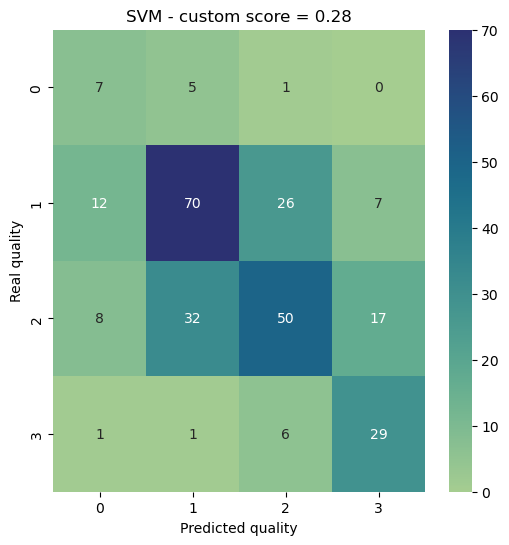

In [18]:
# SVM scores
print(SVM_grid.best_estimator_.steps[1][1])
print("SVM - test data after tuning", end="\n")
print(f"SVM - custom score after tuning: {SVM_custom_score:.2f}", end="\n")
print(SVM_cf, end="\n\n\n")

fig = plt.figure(figsize=(6,6))
ax= plt.subplot()
sns.heatmap(SVM_cf,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")


ax.set_xlabel('Predicted quality')
ax.set_ylabel('Real quality')
ax.set_title(f'SVM - custom score = {SVM_custom_score:.2f}')
pass

In [83]:
# XGB tuning - XGB requires further investigation, because sample weight can be implemented during the fitting
# and comparable results was not included in basic model comparison table
XGB_model_basic = basic_models["XGBoostClassifier"]
XGB_scaler = scalers["quantile_transformer_normal"]
                     
XGB_pipeline_result = Pipeline([('scaler', XGB_scaler),
                                ('model', XGB_model_basic)])  

XGB_parameter_grid = {"model__max_depth": np.arange(2, 6),
                      'model__n_estimators': range(60, 180, 40),
                      'model__learning_rate': [0.05, 0.1]}

# creating a scorer for GridSearch
scorer = make_scorer(custom_metric, greater_is_better=True)
XGB_grid = GridSearchCV(XGB_pipeline_result,
                        XGB_parameter_grid,
                        cv=skf,
                        scoring=scorer)

weights_dictionary = {0: class_0_weight, 1: class_1_weight, 2: class_2_weight, 3: class_3_weight}
classes_weights_y_train = [weights_dictionary[value] for value in y_train]
XGB_model_tuned = XGB_grid.fit(X_train, y_train, model__sample_weight=classes_weights_y_train) # implementing weights for each class

XGB_y_test_pred = XGB_model_tuned.predict(X_test)      
XGB_cf = confusion_matrix(y_test, XGB_y_test_pred)
XGB_custom_score = custom_final_score(XGB_cf, recall_0_weight, recall_3_weight)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=8,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
XGB - test data after tuning
XGB - custom score after tuning: 0.22
[[ 6  6  1  0]
 [10 65 32  8]
 [ 5 31 38 33]
 [ 0  1  6 30]]




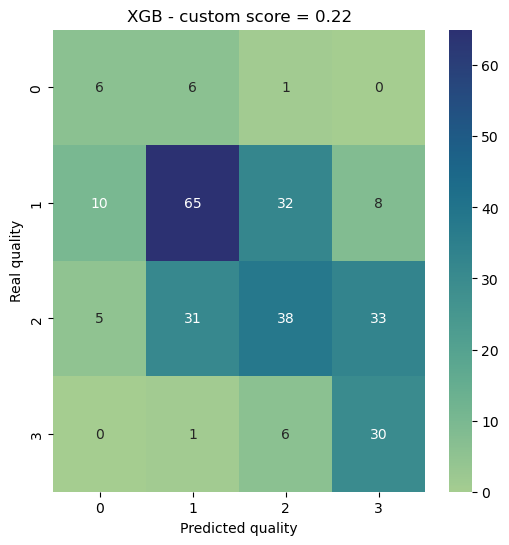

In [84]:
# XGB scores
print(XGB_grid.best_estimator_.steps[1][1])
print("XGB - test data after tuning", end="\n")
print(f"XGB - custom score after tuning: {XGB_custom_score:.2f}", end="\n")
print(XGB_cf, end="\n\n\n")

fig = plt.figure(figsize=(6,6))
ax= plt.subplot()
sns.heatmap(XGB_cf,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")


ax.set_xlabel('Predicted quality')
ax.set_ylabel('Real quality')
ax.set_title(f'XGB - custom score = {XGB_custom_score:.2f}')
pass

In [85]:
# RF tuning
RF_model_basic = basic_models["RandomForestClassifier"]
RF_scaler = scalers["power_transformer_YeoJohnson"]
                     
RF_pipeline_result = Pipeline([('scaler', RF_scaler),
                                ('model', RF_model_basic)])  

RF_parameter_grid = {'model__n_estimators': [100,200],
        'model__max_depth': [10,15,20],
        'model__criterion': ['gini', 'entrophy'],
        'model__min_samples_split': [2,3,4],
        'model__bootstrap': [True, False]}

# creating a scorer for GridSearch
scorer = make_scorer(custom_metric, greater_is_better=True)
RF_grid = GridSearchCV(RF_pipeline_result,
                        RF_parameter_grid,
                        cv=skf,
                        scoring=scorer)


RF_model_tuned = RF_grid.fit(X_train, y_train)

RF_y_test_pred = RF_model_tuned.predict(X_test)      
RF_cf = confusion_matrix(y_test, RF_y_test_pred)
RF_custom_score = custom_final_score(RF_cf, recall_0_weight, recall_3_weight)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_split=3, n_estimators=200, random_state=42)
RF - test data after tuning
RF - custom score after tuning: 0.15
[[ 4  7  2  0]
 [ 4 78 30  3]
 [ 0 34 54 19]
 [ 0  2 13 22]]




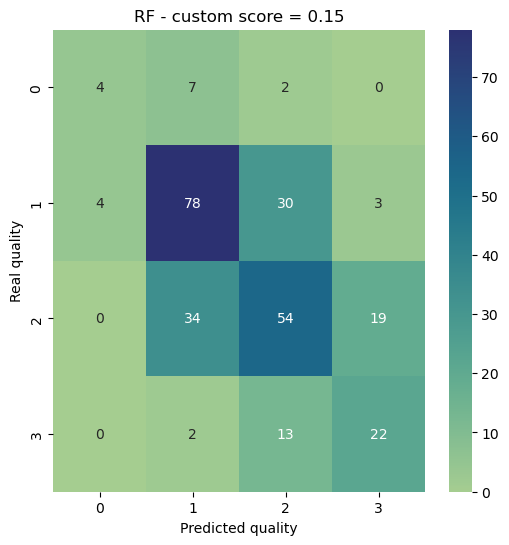

In [86]:
# RF scores
print(RF_grid.best_estimator_.steps[1][1])
print("RF - test data after tuning", end="\n")
print(f"RF - custom score after tuning: {RF_custom_score:.2f}", end="\n")
print(RF_cf, end="\n\n\n")

fig = plt.figure(figsize=(6,6))
ax= plt.subplot()
sns.heatmap(RF_cf,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")


ax.set_xlabel('Predicted quality')
ax.set_ylabel('Real quality')
ax.set_title(f'RF - custom score = {RF_custom_score:.2f}')
pass

# Exporting the best model

In [ ]:
# Saving best model as pickle file
import gzip, pickle
with gzip.open('model.pklz', 'wb') as file:
    pickle.dump(SVM_model_tuned, file)